#Comparing Genetic Algorithms and Gradient-Based Algorithms for Neural Network Training

Genetic algorithms are bio-inspired algorithms known for their ability to solve convex optimization problems. Unlike gradient-based algorithms, which often fall into local minima and may not reach the global minimum, genetic algorithms use evolutionary principles to explore the solution space more comprehensively.

While gradient-based algorithms can efficiently find solutions, they sometimes get stuck in suboptimal points. In contrast, bio-inspired algorithms like the Genetic Algorithm employ mechanisms such as selection, crossover, and mutation to escape local optima and search for more optimal solutions. This characteristic makes genetic algorithms particularly effective for complex optimization problems where a global solution is desired.


### Training a Neural network using Genetic Algorithm

In this notebook we have tried to illustrate how
we can train a MLP3 neural network using Genetic
Algorithm and compare its performance with gradient descent algorithm.
We are doing a regression analysis for the
iris dataset. The neural network that we are using has 3
input neurons, tunable hidden neurons and 1 output
neuron. The goal is to obtain the optimal solution for the
problem.The project using the tools and libraries in
python. The neural network consists of a single hidden
layer.

## Importing necessary libraries

In [1]:
import math
import sklearn.datasets
dataset = sklearn.datasets.load_iris()
from sklearn.model_selection import train_test_split

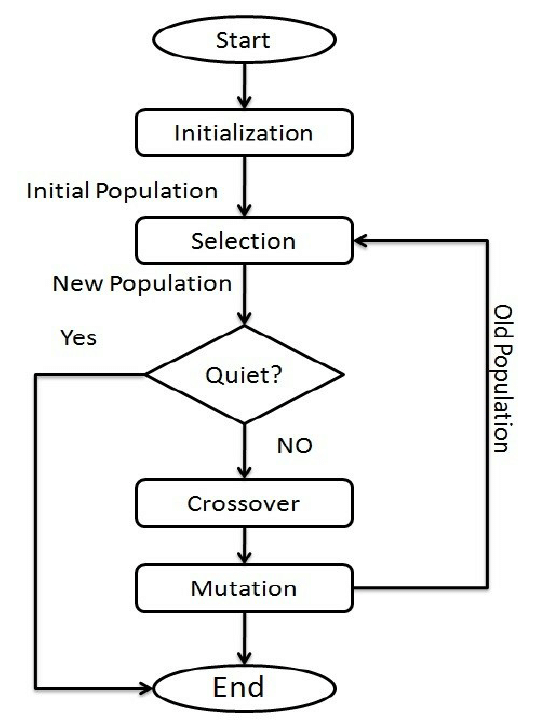

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data visualization

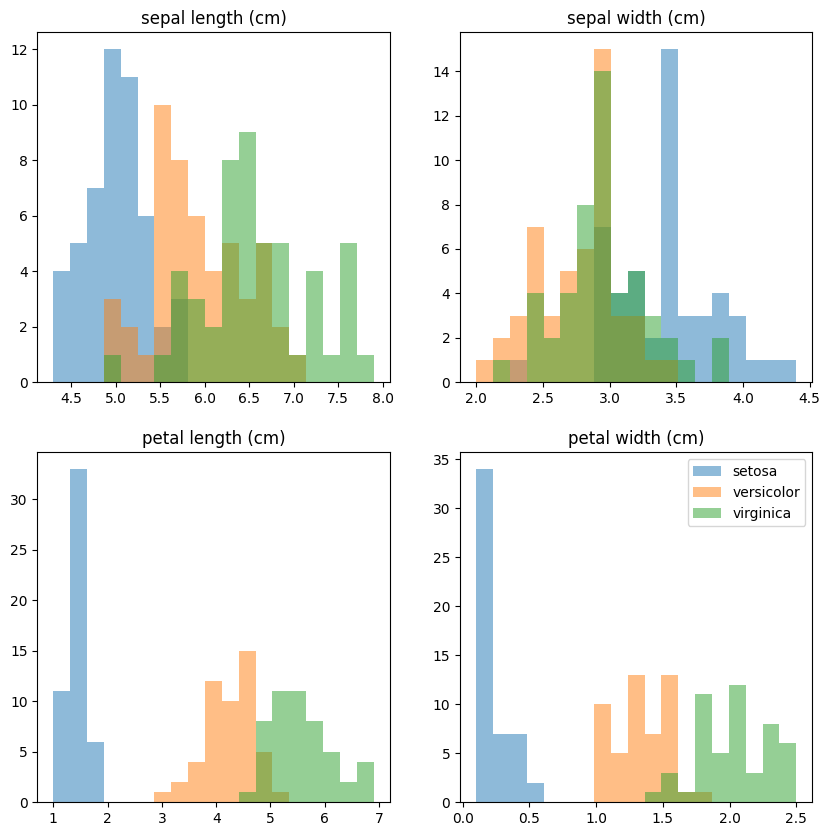

In [3]:
data = dataset['data']
labels = dataset['target']
var_names = dataset['feature_names']
target_names = dataset['target_names']

fig = plt.figure(figsize=(10,10))

for i in range(4):
    plt.subplot(2,2,i+1)
    values = data[:,i]
    bins = np.linspace( np.min(values), np.max(values), 20)
    for j in np.unique(labels):
        categ_values = values[labels==j]
        plt.hist(categ_values, bins, alpha=0.5, label=target_names[j])
    plt.title(var_names[i])
plt.legend()



## Data Preprocessing

In [4]:
dataFrame = pd.DataFrame(dataset['data'], columns= dataset['feature_names'])
dataFrame['class'] = dataset['target']
dataFrame['flower'] = [dataset['target_names'][i] for i in dataset['target']]
dataFrame.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class,flower
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [5]:
dataFrame = dataFrame.sample(frac=1).reset_index(drop=True)
dataFrame.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class,flower
0,5.0,3.4,1.5,0.2,0,setosa
1,4.8,3.4,1.9,0.2,0,setosa
2,4.8,3.1,1.6,0.2,0,setosa
3,5.0,3.3,1.4,0.2,0,setosa
4,4.9,3.0,1.4,0.2,0,setosa


### Scaling

In [6]:
X_min = -1
X_max = 1

# Linear Scaling the feature sets
for cols in dataFrame.columns:
    if cols not in ['class', 'flower', 'petal width (cm)']:
        dataFrame[cols] = X_min +(((dataFrame[cols]-dataFrame[cols].min())/(dataFrame[cols].max() - dataFrame[cols].min()))*(X_max-X_min))

# Min-Max scaling label
for cols in dataFrame.columns:
    if cols == 'petal width (cm)':
        dataFrame[cols] = (dataFrame[cols] - dataFrame[cols].min())/(dataFrame[cols].max() - dataFrame[cols].min())


dataFrame.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class,flower
0,-0.611111,0.166667,-0.830508,0.041667,0,setosa
1,-0.722222,0.166667,-0.694915,0.041667,0,setosa
2,-0.722222,-0.083333,-0.796610,0.041667,0,setosa
3,-0.611111,0.083333,-0.864407,0.041667,0,setosa
4,-0.666667,-0.166667,-0.864407,0.041667,0,setosa


In [7]:
features = dataFrame[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)']].to_numpy()
label = dataFrame['petal width (cm)'].to_numpy()

### Train test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, label)

## Defining the Weight Class for Our Neural Network

In this section, we create a custom `Weight` class to manage the parameters of our neural network. This class will help us initialize, update, and manage the weights efficiently, ensuring our model learns effectively during training. By encapsulating weight-related operations within a dedicated class, we enhance the modularity and maintainability of our code.


In [9]:
# Creating Weight Class To Initilize Weight Of Population

class Weights:
  def __init__(self, n_inputs, n_hidden, n_output):
    self.n_inputs = n_inputs
    self.n_hidden = n_hidden
    self.n_output = n_output

    self.bias_hidden = np.random.randint(low=999001, high=1000999, size=n_hidden)
    self.input_to_hidden = np.random.randint(low=999001, high=1000999, size=(n_inputs, n_hidden))
    self.hidden_to_output = np.random.randint(low=999001, high=1000999, size=(n_hidden, n_output))
    self.bias_output = np.random.randint(low=999001, high=1000999, size=n_output)

  def binaryConv(self, dec):
    binary_val = bin(dec).replace('0b', '')
    while len(binary_val) < 25:
      binary_val = '0' + binary_val
    return binary_val


  def toBinary(self):
    bias_hidden = np.vectorize(self.binaryConv)(self.bias_hidden)
    input_to_hidden = np.vectorize(self.binaryConv)(self.input_to_hidden)
    hidden_to_output = np.vectorize(self.binaryConv)(self.hidden_to_output)
    bias_output = np.vectorize(self.binaryConv)(self.bias_output)
    return bias_hidden, input_to_hidden, hidden_to_output, bias_output

  def scaling_shifting(self, x):
    val = x - 1000000
    val = (val/1000)
    return val

  def getWeights(self):
    bias_hidden = np.vectorize(self.scaling_shifting)(self.bias_hidden)
    input_to_hidden = np.vectorize(self.scaling_shifting)(self.input_to_hidden)
    hidden_to_output = np.vectorize(self.scaling_shifting)(self.hidden_to_output)
    bias_output = np.vectorize(self.scaling_shifting)(self.bias_output)
    return bias_hidden, input_to_hidden, hidden_to_output, bias_output


  def printWeight(self):
    print("Bias Of Hidden: \n", self.bias_hidden)
    print("Weight From Input To Hidden Layer: \n", self.input_to_hidden)
    print("Bias Of Output: \n", self.bias_output)
    print("Weight From Hidden To Output Layer: \n", self.hidden_to_output)

## Implementing the NeuralNetwork Class with Genetic Algorithm Training

In this section, we define the `NeuralNetwork` class, which contains various stages of genetic algorithm like `checkFitness`, `selection`, `crossover` and `mutation`. This innovative approach leverages evolutionary principles to optimize the network's performance. The class utilizes our previously defined `Weight` class to manage and update the network parameters efficiently. By combining genetic algorithms with a well-structured weight management system, we aim to enhance the learning capability and robustness of our neural network.


In [10]:
class NeuralNetwork:

  def __init__(self, X_train, y_train, population_size = 20, n_hidden=3, fittness_thres = 0.95):
    self.X_train = X_train
    self.y_train = y_train
    self.population_size = population_size
    self.Weights = [Weights(X_train.shape[1], n_hidden, 1) for _ in range(self.population_size)]
    self.no_input = self.X_train.shape[1]
    self.precision = 1000
    self.no_of_hidden = n_hidden
    self.no_output = 1
    self.fittness_thres = fittness_thres
    self.fittness_score = [0 for _ in range(self.population_size)]
    self.cross_len = 7

  def sigmoid(self,gamma):
        return (1/(1+math.exp(-gamma)))

  def gamma(self,bias,wt,inputt):
      return (np.dot(wt,inputt)+bias)

  def feedforward(self, inputs, weight):
        hidden_layer_outputs = []
        for i in range(0, self.no_of_hidden):
            hidden_layer_outputs.append(self.sigmoid(self.gamma(weight['bias_hidden'][i], weight['input_to_hidden'].T[i], inputs)))
        outputs = []
        hidden_layer_outputs = np.array(hidden_layer_outputs)
        for i in range(0, self.no_output):
            outputs.append(self.gamma(weight['bias_output'][i], weight['hidden_to_output'].T[i], hidden_layer_outputs))

        return np.array(outputs)[0]


  def checkFitness(self):
    temp = 0
    for weight in self.Weights:
      w = dict()
      w['bias_hidden'], w['input_to_hidden'], w['hidden_to_output'], w['bias_output'] = weight.getWeights()
      # print(w)
      error = 0
      for i in range(len(self.X_train)):
        y = self.feedforward(self.X_train[i], w)
        error += self.computeError(y, self.y_train[i])

      self.fittness_score[temp] = (1/error)
      temp+=1


  def computeError(self, y, d):
    error = (0.5*((y-d)*(y-d)))
    return (error)

  def decConv(self, bin_val):
    return int(bin_val, 2)

  def selection(self,):
    order = np.argsort(self.fittness_score)
    return order

  def performCrossing(self, a, b):
    cross_len = np.random.choice([5,4,3,2,1])
    temp1 = a[:len(b)- cross_len]+b[-cross_len:]
    temp2 = b[:len(b)-cross_len]+a[-cross_len:]
    return temp1, temp2

  def crossover(self, order):
    selected = order[-2:]
    first, second = selected[1], selected[0]
    # print(first, second)
    first_bin_wt = self.Weights[first].toBinary()
    second_bin_wt = self.Weights[second].toBinary()
    crossover1 = Weights(self.no_input, self.no_of_hidden, self.no_output)
    crossover2 = Weights(self.no_input, self.no_of_hidden, self.no_output)


    bias_hidden_first = first_bin_wt[0]
    bias_hidden_second = second_bin_wt[0]
    for i in range(self.no_of_hidden):
      crossval1, crossval2 = self.performCrossing(bias_hidden_first[i],bias_hidden_second[i])
      crossover1.bias_hidden[i] = self.decConv(crossval1)
      crossover2.bias_hidden[i] = self.decConv(crossval2)


    input_to_hidden_first = first_bin_wt[1]
    input_to_hidden_second = second_bin_wt[1]
    for i in range(self.no_input):
      for j in range(self.no_of_hidden):
        crossval1, crossval2 = self.performCrossing(input_to_hidden_first[i][j],input_to_hidden_second[i][j])
        crossover1.input_to_hidden[i][j] = self.decConv(crossval1)
        crossover2.input_to_hidden[i][j] = self.decConv(crossval2)


    hidden_to_output_first = first_bin_wt[2]
    hidden_to_output_second = second_bin_wt[2]
    for i in range(self.no_of_hidden):
      for j in range(self.no_output):
        crossval1, crossval2 = self.performCrossing(hidden_to_output_first[i][j],hidden_to_output_second[i][j])
        crossover1.hidden_to_output[i][j] = self.decConv(crossval1)
        crossover2.hidden_to_output[i][j] = self.decConv(crossval2)


    bias_output_first = first_bin_wt[3]
    bias_output_second = second_bin_wt[3]
    for i in range(self.no_output):
      crossval1, crossval2 = self.performCrossing(bias_output_first[i],bias_output_second[i])
      crossover1.bias_output[i] = self.decConv(crossval1)
      crossover2.bias_output[i] = self.decConv(crossval2)

    last1, last2 = order[:2]
    # print(last1, last2)
    self.Weights[last1] = crossover1
    self.Weights[last2] = crossover2


  def bitFlip(self, x, pos= 0):
    pos = np.random.choice([16, 17, 18, 19, 20, 21, 22])
    if x[pos] == '0':
      return x[:pos] + '1' + x[pos+1:]
    elif x[pos] == '1':
      return x[:pos] + '0' + x[pos+1:]
    else:
      raise Exception('someting went wrong')


  def mutation(self, order):
    for i in order[-4:-2]:
      bias_hidden, input_to_hidden, hidden_to_output, bias_output = self.Weights[i].toBinary()
      # print((np.vectorize(self.bitFlip)(bias_hidden)))
      self.Weights[i].bias_hidden = np.vectorize(self.decConv)(np.vectorize(self.bitFlip)(bias_hidden))
      self.Weights[i].input_to_hidden = np.vectorize(self.decConv)(np.vectorize(self.bitFlip)(input_to_hidden))
      self.Weights[i].hidden_to_output = np.vectorize(self.decConv)(np.vectorize(self.bitFlip)(hidden_to_output))
      self.Weights[i].bias_output = np.vectorize(self.decConv)(np.vectorize(self.bitFlip)(bias_output))



## Defining the MLP3 Class with Gradient Descent Training

In this section, we introduce the `MLP3` class, a multi-layer perceptron (MLP) that utilizes gradient descent as its training algorithm. This class is designed to optimize the network's weights by minimizing the loss function through iterative updates. By leveraging gradient descent, `MLP3` aims to efficiently learn from the data, improving its performance with each epoch.


In [11]:
class MLP3:
    def __init__(self, X, y, no_of_hidden_neuron, alpha=0.001):
        self.X = X
        self.y = y
        self.no_of_hidden = no_of_hidden_neuron
        self.no_input = self.X.shape[1]
        self.no_output = 1
        self.alpha = alpha
        self.wt_input_hidden = np.random.random_sample(self.no_input*self.no_of_hidden).reshape(self.no_input, self.no_of_hidden)
        self.bias_hidden = np.random.random_sample(self.no_of_hidden)
        self.wt_hidden_output = np.random.random_sample(self.no_output*self.no_of_hidden).reshape(self.no_of_hidden, self.no_output)
        self.bias_output = np.random.random_sample(self.no_output)
        self.d_wt_input_hidden = np.array([[0 for i in range(self.no_of_hidden)] for j in range(self.no_input)])
        self.d_bias_hidden = np.array([0 for i in range(self.no_of_hidden)])
        self.d_wt_hidden_output = np.array([[0 for i in range(self.no_output)] for j in range(self.no_of_hidden)])
        self.d_bias_output = [0 for i in range(self.no_output)]
        self.avg_error = []
        self.error_list = []


    def sigmoid(self,gamma):
        import math
        return (1/(1+math.exp(-gamma)))


    def gamma(self,bias,wt,inputt):
        return (np.dot(wt,inputt)+bias)


    def feedforward(self, inputs):
        hidden_layer_outputs = []
        for i in range(0, self.no_of_hidden):
            hidden_layer_outputs.append(self.sigmoid(self.gamma(self.bias_hidden[i], self.wt_input_hidden.T[i], inputs)))
        outputs = []
        hidden_layer_outputs = np.array(hidden_layer_outputs)
        for i in range(0, self.no_output):
            outputs.append(self.gamma(self.bias_output[i], self.wt_hidden_output.T[i], hidden_layer_outputs))

        return hidden_layer_outputs , np.array(outputs)


    def Error(self, y, d):
        return 0.5*((y-d)*(y-d))


    def Sample_Weight_Update(self, index, hidden_layer_outputs, output):
        i = 0
        for Xi in self.X[index]:
          self.wt_input_hidden[i] =  self.wt_input_hidden[i] + self.alpha*(self.y[index][0] - output)*((self.wt_hidden_output.T[0])*(hidden_layer_outputs-np.square(hidden_layer_outputs)))*Xi
          i+=1

        self.bias_hidden = self.bias_hidden + self.alpha*(self.y[index][0] - output)*(self.wt_hidden_output.T[0])*(hidden_layer_outputs-np.square(hidden_layer_outputs))
        self.bias_output = self.bias_output + self.alpha*(self.y[index][0] - output)
        self.wt_hidden_output = self.wt_hidden_output + self.alpha*((self.y[index][0] - output)*np.array([hidden_layer_outputs]).T)

    def Derivative_Sum(self, index, hidden_layer_outputs, output):

      i = 0
      for Xi in self.X[index]:
        self.d_wt_input_hidden[i] = self.d_wt_input_hidden[i] - (output - self.y[index][0])*((self.wt_hidden_output.T[0])*(hidden_layer_outputs-np.square(hidden_layer_outputs)))*Xi
        i+=1

      #self.d_wt_input_hidden = self.d_wt_input_hidden + np.array([[(self.y[index][0] - output)*((self.wt_hidden_output.T[0])*(hidden_layer_outputs-np.square(hidden_layer_outputs)))*Xi] for Xi in self.X[index]])
      self.d_bias_hidden = self.d_bias_hidden - (output - self.y[index][0])*(self.wt_hidden_output.T[0])*(hidden_layer_outputs-np.square(hidden_layer_outputs))
      self.d_bias_output = self.d_bias_output - (output - self.y[index][0])
      self.d_wt_hidden_output = self.d_wt_hidden_output - ((output - self.y[index][0])*np.array([hidden_layer_outputs]).T)


    def Batch_Weight_Update(self):
      self.wt_input_hidden = self.wt_input_hidden + self.alpha*self.d_wt_input_hidden
      self.bias_hidden = self.bias_hidden + self.alpha*self.d_bias_hidden
      self.bias_output = self.bias_output + self.alpha*self.d_bias_output
      self.wt_hidden_output = self.wt_hidden_output + self.alpha*self.d_wt_hidden_output

      self.d_wt_input_hidden = np.array([[0 for i in range(self.no_of_hidden)] for j in range(self.no_input)])
      self.d_bias_hidden = np.array([0 for i in range(self.no_of_hidden)])
      self.d_wt_hidden_output = np.array([[0 for i in range(self.no_output)] for j in range(self.no_of_hidden)])
      self.d_bias_output = [0 for i in range(self.no_output)]

    def score(self, X, y):
      output2 = []
      error = []
      k = 0
      for i in X:
        # print(i)
        h_o , output = self.feedforward(i)
        output2.append(output[0])
        error.append(self.Error(y[k], output[0]))
        k+=1

      return output2, error


    def Train(self, no_iter=20, training_method = "Sample"):
        if training_method == "Sample":
          for i in range(no_iter):
              for j in range(len(self.X)):
                  Zs, d = self.feedforward(self.X[j])
                  self.error_list.append(self.Error(d[0] ,self.y[j]))
                  self.Sample_Weight_Update(index = j, hidden_layer_outputs = Zs , output = d[0])

              self.avg_error.append(sum(self.error_list)/len(self.error_list))

          plt.scatter([i for i in range(len(self.avg_error))], np.array(self.avg_error))

        elif training_method == "Batch":
          for i in range(no_iter):
            for j in range(len(self.X)):
              Zs, d = self.feedforward(self.X[j])
              self.error_list.append(self.Error(d[0] ,self.y[j]))
              self.Derivative_Sum(j, Zs, d[0])

            self.Batch_Weight_Update()
            self.avg_error.append(sum(self.error_list)/len(self.error_list))

          plt.plot([i for i in range(len(self.avg_error)-50)], np.array(self.avg_error)[50:])
        #plt.scatter([i for i in range(len(error_list))], np.array(error_list).reshape(1, len(error_list))[0])
        print('Model Trained')


## Genetic Algorithm Training Function (GA)

The `GA` function demonstrates the training process of our `NeuralNetwork` class using a genetic algorithm. This function initializes the neural network with a specified population size and number of hidden units, then iteratively improves the network's performance over 5000 generations. Key steps include:

- **Fitness Evaluation:** Assessing the performance of each individual in the population.
- **Selection:** Choosing the fittest individuals to participate in the next generation.
- **Crossover:** Combining pairs of selected individuals to produce offspring.
- **Mutation:** Introducing random changes to offspring to maintain genetic diversity.

The error at each iteration is recorded and appended to the `error` list for analysis. By following these steps, the genetic algorithm aims to evolve the neural network towards optimal performance.

```
GA()
   initialize population
   find fitness of population
   
   while (termination criteria is reached) do
      parent selection
      crossover with probability pc
      mutation with probability pm
      decode and fitness calculation
      survivor selection
      find best
   return best
```






In [12]:
error = []
def GA():
  nn = NeuralNetwork(X_train, y_train, n_hidden=5, population_size=10)
  nn.checkFitness()
  i = 0
  while i < 5000:
    order = nn.selection()
    print(nn.fittness_score)
    print(order)
    nn.crossover(order)
    order = nn.selection()
    nn.mutation(order)
    nn.checkFitness()
    error.append(1/(nn.fittness_score[order[-1]]*112))
    i+=1

## Training the MLP3 Neural Network with Backpropagation

In this section, we instantiate the `MLP3` class with 5 hidden neurons and a learning rate (`alpha`) of 0.01. The network is trained on the training data for 1000 epochs using the batch gradient descent method.

Model Trained


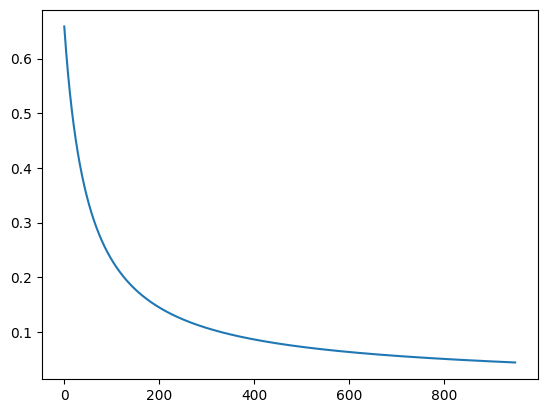

In [13]:
BackProp = MLP3(X_train, y_train.reshape((112,1)), no_of_hidden_neuron=5, alpha=0.01)
BackProp.Train(1000, training_method='Batch')

### Final average error from gradient descent algorithm

In [14]:
BackProp.avg_error[-1]

array([0.0439686])

## Executing the Genetic Algorithm Training Function (GA)

We now execute the `GA()` function to train our `NeuralNetwork` using a genetic algorithm.

In [15]:
GA()

Streaming output truncated to the last 5000 lines.
[1.048186325100029, 1.0289676577312483, 1.0166232633987977, 0.4190729551215371, 1.015819092355984, 0.6080811579580379, 1.048186325100029, 1.0166430155424724, 1.048186325100029, 1.048186325100029]
[3 5 4 2 7 1 0 6 8 9]
[0.5102561323877607, 1.0289676577312483, 1.0166232633987977, 1.048186325100029, 1.015819092355984, 1.048186325100029, 0.8584946200463722, 1.0166430155424724, 1.048186325100029, 1.048186325100029]
[0 6 4 2 7 1 3 5 8 9]
[1.048186325100029, 1.0289676577312483, 1.0166232633987977, 0.1292305203618717, 1.015819092355984, 0.6738373447327799, 1.048186325100029, 1.0166430155424724, 1.048186325100029, 1.048186325100029]
[3 5 4 2 7 1 0 6 8 9]
[0.17156700720514406, 1.0289676577312483, 1.0166232633987977, 1.048186325100029, 1.015819092355984, 1.048186325100029, 0.16092934512790869, 1.0166430155424724, 1.048186325100029, 1.048186325100029]
[6 0 4 2 7 1 3 5 8 9]
[1.048186325100029, 1.0289676577312483, 1.0166232633987977, 0.4236993531672

In [16]:
error[-1]

0.008518114780518025

### Error curve for genetic algorithm

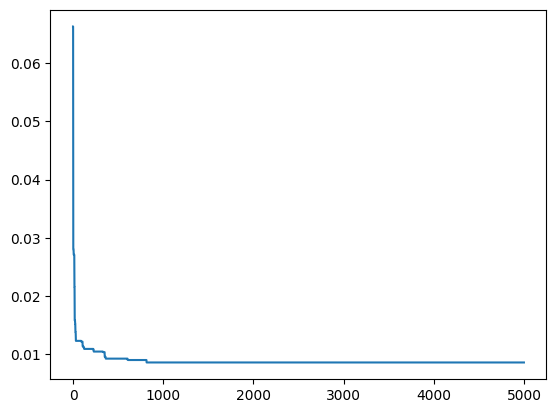

In [17]:
plt.plot(error)